In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob 


from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Project 1

- ImageDataGenrator와 TL을 이용해서 오버 피팅이 최소가 되게 정확도 90% 이상 달성.

- 만약 오버 피팅이 심하고 90% 이상의 성능이 나오지 않는다면, 문제점과 개선안을 찾아본다.

# 엑스레이 

- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- 과적합적고 정확도 90이상.

- val은 train 10% 이상되게

## 경로 설정

In [2]:
# ROOT_DIR = 'content'
# DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Chest_Xray_Pneumonia')
# TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
# TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
# VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")


In [2]:
#### Colab
ROOT_DIR = '/content'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Chest_Xray_Pneumonia')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'val')

## 데이터셋 가져오기

In [3]:
# #### Colab

# from google.colab import drive

# drive.mount('/content/gdrive')

# shutil.copy(os.path.join('/content/gdrive/My Drive/Colab Notebooks/', 'Chest_Xray_Pneumonia.zip'))

# if os.path.exists(DATA_ROOT_DIR):
#     shutil.rmtree(DATA_ROOT_DIR)
    
# with zipfile.ZipFile(os.path.join(ROOT_DIR, 'Chest_Xray_Pneumonia.zip'), 'r') as target_file:
#     target_file.extractall(DATA_ROOT_DIRA_ROOT_DIR)

from google.colab import drive 

drive.mount("/content/gdrive")

data_path = "/content/gdrive/MyDrive/"

ROOT_DIR = "/content"

DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Chest_Xray_Pneumonia")

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")

shutil.copy(os.path.join(data_path, "Chest_Xray_Pneumonia.zip"), ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "Chest_Xray_Pneumonia.zip")) as target_file:   
  target_file.extractall(DATA_ROOT_DIR)
  print("success!")

Mounted at /content/gdrive
success!


In [5]:
# #### PC
# if os.path.exists(DATA_ROOT_DIR):
#     shutil.rmtree(DATA_ROOT_DIR)

# with zipfile.ZipFile(os.path.join(ROOT_DIR, 'archive (3).zip'), 'r') as target_file:
#     target_file.extractall(DATA_ROOT_DIR)

In [6]:
os.listdir('C:\dohyun0207\PythonWork\AI\content\Chest_Xray_Pneumonia\chest_xray')

FileNotFoundError: ignored

## 정답및 전체 데이터 갯수 확인

In [4]:
print(os.listdir(TRAIN_DATA_ROOT_DIR))
print(TRAIN_DATA_ROOT_DIR)

for i in range(len(os.listdir(TRAIN_DATA_ROOT_DIR))):
    
    path = os.path.join(TRAIN_DATA_ROOT_DIR, os.listdir(TRAIN_DATA_ROOT_DIR)[i])
    print('Train ', os.listdir(TRAIN_DATA_ROOT_DIR)[i], len(os.listdir(path)))
    
print('=========' * 6)

for i in range(len(os.listdir(TEST_DATA_ROOT_DIR))):
    
    path = os.path.join(TEST_DATA_ROOT_DIR, os.listdir(TEST_DATA_ROOT_DIR)[i])
    print('Test ', os.listdir(TEST_DATA_ROOT_DIR)[i], len(os.listdir(path)))
    
print('=========' * 6)
    
for i in range(len(os.listdir(TEST_DATA_ROOT_DIR))):
    
    path = os.path.join(VALIDATION_DATA_ROOT_DIR, os.listdir(VALIDATION_DATA_ROOT_DIR)[i])
    print('Val ', os.listdir(VALIDATION_DATA_ROOT_DIR)[i], len(os.listdir(path)))

['PNEUMONIA', 'NORMAL']
/content/Chest_Xray_Pneumonia/train
Train  PNEUMONIA 3875
Train  NORMAL 1341
Test  PNEUMONIA 390
Test  NORMAL 234
Val  PNEUMONIA 8
Val  NORMAL 8


## Image Shape 설정

In [5]:
IMG_WIDTH = 100
IMG_HEIGHT = 100

## ImageDataGenerator를 이용하여 데이터 불러오기

In [6]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True,
                                                subset='training')

val_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True,
                                                subset='validation')

test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### 16 장의 이미지 확인

- ImageDataGenerator를 통해 전달된 이미지 출력

In [9]:
img, label = train_generator.next()
img = img[:16]
label = label[:16]

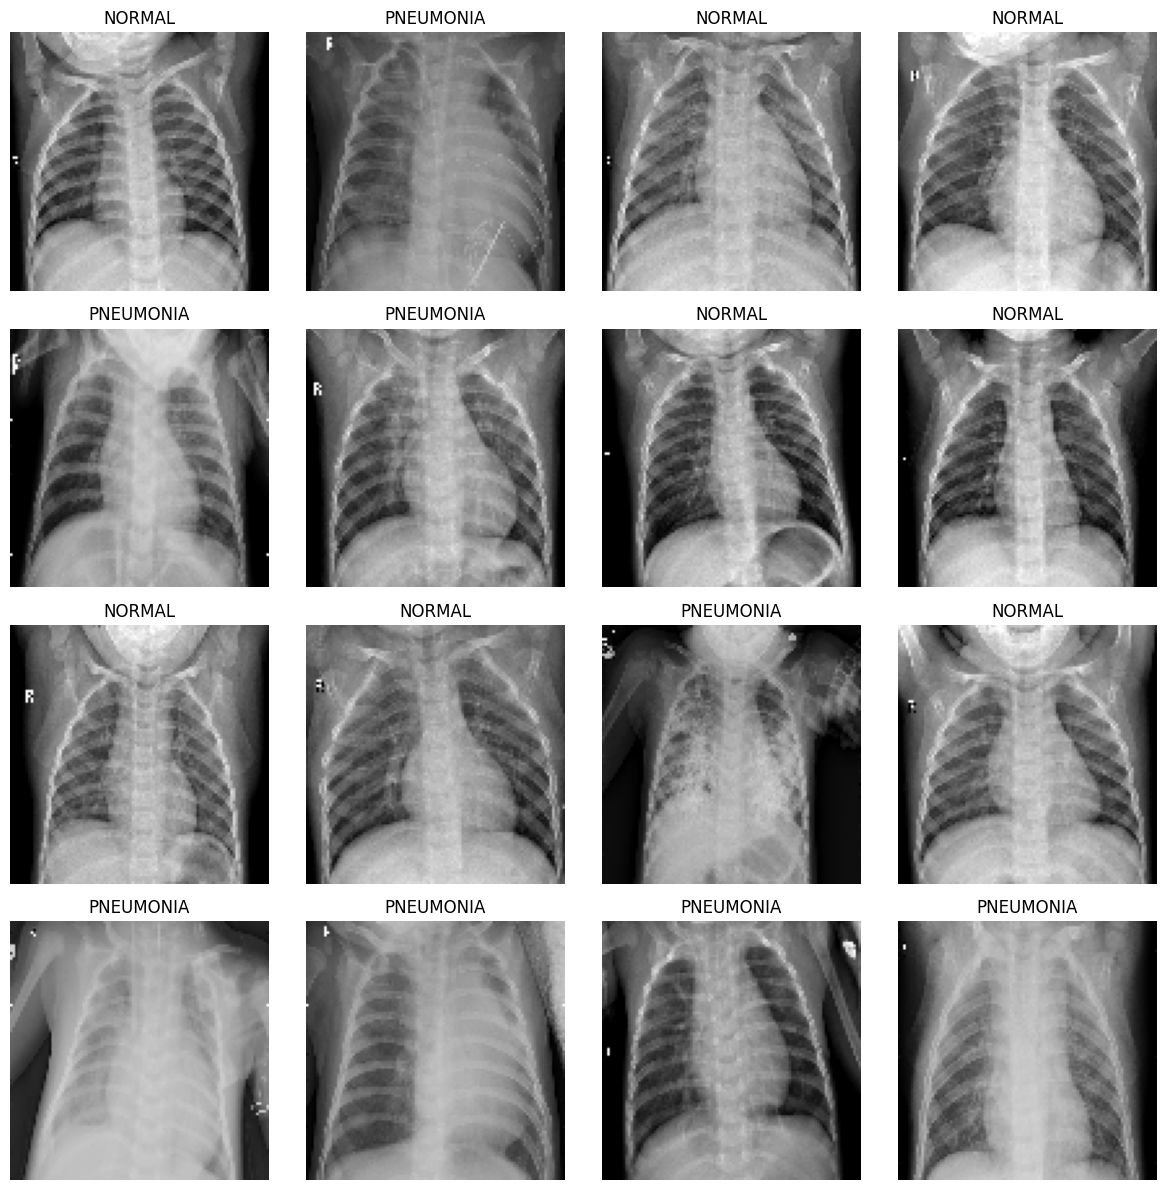

In [10]:
class_name = {0:'NORMAL', 1:'PNEUMONIA'}   
    
plt.figure(figsize=(12, 12))
for i in range(len(img)):
    plt.subplot(4, 4, i+1)
    plt.title(class_name[int(label[i])])
    plt.imshow(img[i])
    plt.axis('off')
plt.tight_layout()
    

## Fine Tuining을 위한 pre-trained 정의 및 모델 구축

In [11]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32) 

In [12]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,245,298
Trainable params: 3,223,410
Non-

In [13]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=Adam(2e-5), metrics=['acc'])

In [14]:
start_time = datetime.now()

result = model.fit(train_generator, epochs=10, validation_data=val_generator) # epochs = 10? 30?

end_time = datetime.now()

print('Run time :', end_time - start_time)

Epoch 1/10
131/131 [==============================] - 98s 534ms/step - loss: 0.6299 - acc: 0.7275 - val_loss: 0.3513 - val_acc: 0.8600
Epoch 2/10
131/131 [==============================] - 84s 639ms/step - loss: 0.2750 - acc: 0.8922 - val_loss: 0.2912 - val_acc: 0.8773
Epoch 3/10
131/131 [==============================] - 71s 545ms/step - loss: 0.2104 - acc: 0.9209 - val_loss: 0.1622 - val_acc: 0.9243
Epoch 4/10
131/131 [==============================] - 63s 482ms/step - loss: 0.1675 - acc: 0.9363 - val_loss: 0.1324 - val_acc: 0.9348
Epoch 5/10
131/131 [==============================] - 71s 541ms/step - loss: 0.1299 - acc: 0.9526 - val_loss: 0.1190 - val_acc: 0.9482
Epoch 6/10
131/131 [==============================] - 64s 488ms/step - loss: 0.1150 - acc: 0.9561 - val_loss: 0.1011 - val_acc: 0.9578
Epoch 7/10
131/131 [==============================] - 63s 478ms/step - loss: 0.1061 - acc: 0.9648 - val_loss: 0.0974 - val_acc: 0.9616
Epoch 8/10
131/131 [==============================] - 7

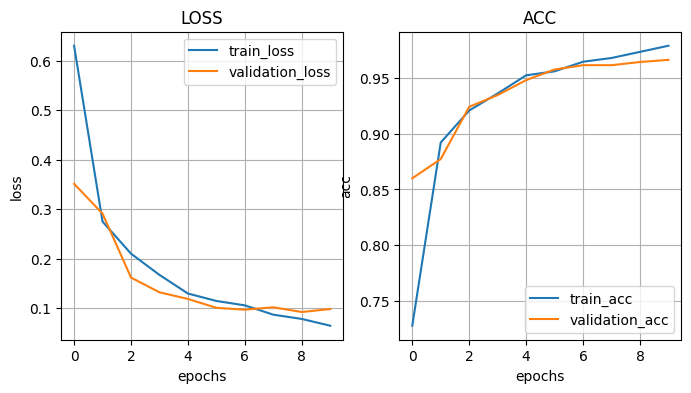

In [15]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")
plt.show()


In [16]:
model.evaluate(test_generator)

20/20 [==============================] - 7s 354ms/step - loss: 0.7509 - acc: 0.8125


[0.7509041428565979, 0.8125]

In [17]:
test_simple_dataget = ImageDataGenerator(rescale = 1./255)

test_simple_generator = train_data_gen.flow_from_directory(directory=VALIDATION_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True,
                                                subset='validation')

Found 2 images belonging to 2 classes.


In [18]:
model.evaluate(test_simple_generator)

1/1 [==============================] - 0s 298ms/step - loss: 1.0264 - acc: 0.5000


[1.026405930519104, 0.5]

In [19]:
# Project-2

### Testing 디렉토리의 모든 파일을 Training 동일 디렉토리로 move

    
#################### test => train
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("train label : ", label_name, " -> ",
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))


['PNEUMONIA', 'NORMAL']
train label :  PNEUMONIA  ->  3875
train label :  NORMAL  ->  1341


In [21]:
####################
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num+1
        
    print(str(move_num) +"is moved into" + label_name+\
         "(Testing => Training)")
## Training 전체 개수 확인

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("train label : ", label_name, " -> ",
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))   

['PNEUMONIA', 'NORMAL']
390is moved intoPNEUMONIA(Testing => Training)
234is moved intoNORMAL(Testing => Training)
['PNEUMONIA', 'NORMAL']
train label :  PNEUMONIA  ->  4265
train label :  NORMAL  ->  1575


In [23]:
 
####################
val_label_name_list = os.listdir(VALIDATION_DATA_ROOT_DIR)
print(val_label_name_list)

for label_name in val_label_name_list:
    print("val label : ", label_name, " -> ",
         len(os.listdir(os.path.join(VALIDATION_DATA_ROOT_DIR, label_name))))

for label_name in val_label_name_list:
    val_path = os.path.join(VALIDATION_DATA_ROOT_DIR, label_name)
    val_file_list = os.listdir(val_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    for val_file in val_file_list:
        shutil.move(os.path.join(val_path, val_file),
                   os.path.join(train_path, val_file))
        move_num = move_num+1
        
    print(str(move_num) +"is moved into" + label_name+\
         "(Testing => Training)")




['PNEUMONIA', 'NORMAL']
val label :  PNEUMONIA  ->  8
val label :  NORMAL  ->  8
8is moved intoPNEUMONIA(Testing => Training)
8is moved intoNORMAL(Testing => Training)


In [24]:

## Shuffle 후 다시 Testing으로

#### 이동할 비율
MOVE_RATIO = .2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    
    train_data_file_list = os.listdir(src)
    
    print('====================================')
    print('total [%s] data file nums => [%s]'%(label_name, len(train_data_file_list)))
    
    
    np.random.shuffle(train_data_file_list)
    print('train data shuffle is done.')
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print('split nums =>', split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
    
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file), 
                   os.path.join(dst, test_data_file))
        
        move_num = move_num + 1
        
    print('total move num =>', move_num)
    print(('===================================='))

total [PNEUMONIA] data file nums => [4273]
train data shuffle is done.
split nums => 854
total move num => 854
total [NORMAL] data file nums => [1583]
train data shuffle is done.
split nums => 316
total move num => 316


나눈후 다시

In [26]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [27]:
train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True,
                                                subset='training')

val_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True,
                                                subset='validation')

test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True)

Found 3750 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [30]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(train_generator.num_classes, activation='softmax'))
model.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

In [31]:

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=Adam(1e-5), metrics=['acc'])

start_time = datetime.now()

result = model.fit(train_generator, epochs=10, validation_data=test_generator)

end_time = datetime.now()

print('Run time :', end_time - start_time)


Epoch 1/10
118/118 [==============================] - 74s 484ms/step - loss: 0.7386 - acc: 0.7464 - val_loss: 0.3924 - val_acc: 0.8504
Epoch 2/10
118/118 [==============================] - 57s 488ms/step - loss: 0.3836 - acc: 0.8608 - val_loss: 0.3813 - val_acc: 0.8615
Epoch 3/10
118/118 [==============================] - 56s 473ms/step - loss: 0.2984 - acc: 0.8909 - val_loss: 0.2758 - val_acc: 0.8983
Epoch 4/10
118/118 [==============================] - 56s 478ms/step - loss: 0.2287 - acc: 0.9141 - val_loss: 0.2347 - val_acc: 0.9197
Epoch 5/10
118/118 [==============================] - 57s 484ms/step - loss: 0.1973 - acc: 0.9328 - val_loss: 0.1970 - val_acc: 0.9368
Epoch 6/10
118/118 [==============================] - 57s 482ms/step - loss: 0.1649 - acc: 0.9371 - val_loss: 0.1718 - val_acc: 0.9350
Epoch 7/10
118/118 [==============================] - 56s 475ms/step - loss: 0.1593 - acc: 0.9469 - val_loss: 0.1716 - val_acc: 0.9385
Epoch 8/10
118/118 [==============================] - 5

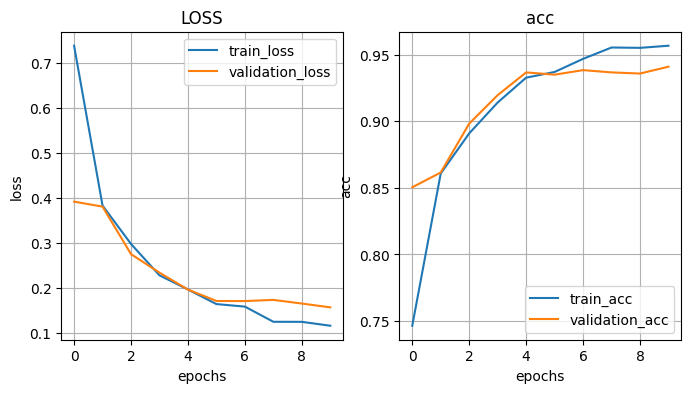

37/37 [==============================] - 14s 366ms/step - loss: 0.1576 - acc: 0.9410


[0.1576080322265625, 0.9410256147384644]

In [32]:

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")
plt.show()


model.evaluate(test_generator)